In [1]:
import numpy as np
import sib_ldsc_z as ld
from scipy.optimize import minimize
from scipy.special import comb
from scipy.misc import derivative
import scipy.stats
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import glob
# import numdifftools as nd
reload(ld)

<module 'sib_ldsc_z' from '/disk/homedirs/nber/harij/gitrepos/SNIPar/ldsc_reg/sib_ldsc_z.py'>

In [2]:
np.random.seed(123)

# N = int(100)
# S_size = int(N/2)
# S = np.array([np.array([[.5, 0], [0, .8]]),
#     np.array([[0.5, 0], [0, 0.8]])] * S_size )/N
# V = np.identity(2) * 0.5

N = int(1e4)
S = np.array([[[1e-4, -5 * 1e-5], [-5 * 1e-5, 1e-4]]] * N)
V = np.array([[0.5, 0.25], [0.25, 0.5]])


# N = int(1e4)
# S = np.array([[[1e-4, -5 * 1e-5, -4 * 1e-5], [-5 * 1e-5, 1e-4, -4 * 1e-5], [-5 * 1e-5, -4 * 1e-5, 1e-4]]] * N)
# V = np.array([[0.5, 0.25, 0.25], [0.25, 0.5, 0.25], [0.25, 0.25, 0.5]])

model = ld.sibreg(S = S)
model.simdata(V/N, N, simld = True)

Warning there is no value for z. Maybe consider simulating it
No value for U given. Generating a vector of ones (all SNPs weighted equally)
No value for LD Scores given. Generating a vector of ones for l
No value for effective number of loci is given. Using total number of loci instead
Simulated LD scores!


In [3]:
# Testing derivatives
aderiv = ld._grad_ll_v(ld.Vmat2V(V, N), model.z[0, :], model.S[0],  model.l[0], N)

nderiv = ld._num_grad_V(ld.Vmat2V(V, N), model.z[0, :], model.S[0], model.l[0],  N)

np.allclose(aderiv, nderiv)

True

In [4]:
# solving
%time output, result = model.solve()
print(result)

No initial guess provided.
Making Method of Moments Guess
Initial estimate: [1.55430175 1.47910632 0.53409088]
CPU times: user 1min 43s, sys: 368 ms, total: 1min 43s
Wall time: 25.2 s
      fun: 37189.05234762348
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02739723, -0.02879562, -0.00672324])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 11
      nit: 8
   status: 0
  success: True
        x: array([0.51801607, 0.49264674, 0.53215414])


/disk/homedirs/nber/harij/gitrepos/SNIPar/ldsc_reg/sib_ldsc_z.py:617: RuntimeWarning: invalid value encountered in sqrt
  std_err_mat = np.sqrt(invH)


In [7]:
output

{'v1': 0.5180160703428222,
 'v2': 0.49264673706599993,
 'r': 0.5321541425848506,
 'std_err_mat': array([[0.01221355, 0.00124924,        nan],
        [0.00124924, 0.01186258,        nan],
        [       nan,        nan, 0.01696686]])}

In [14]:
%time model.jackknife_se(blocksize=100, printinfo=True)

Loop Number: 1
Current Block: 0 to 100
Loop Number: 2
Current Block: 100 to 200
Loop Number: 3
Current Block: 200 to 300
Loop Number: 4
Current Block: 300 to 400
Loop Number: 5
Current Block: 400 to 500
Loop Number: 6
Current Block: 500 to 600
Loop Number: 7
Current Block: 600 to 700
Loop Number: 8
Current Block: 700 to 800
Loop Number: 9
Current Block: 800 to 900
Loop Number: 10
Current Block: 900 to 1000
Loop Number: 11
Current Block: 1000 to 1100
Loop Number: 12
Current Block: 1100 to 1200
Loop Number: 13
Current Block: 1200 to 1300
Loop Number: 14
Current Block: 1300 to 1400
Loop Number: 15
Current Block: 1400 to 1500
Loop Number: 16
Current Block: 1500 to 1600
Loop Number: 17
Current Block: 1600 to 1700
Loop Number: 18
Current Block: 1700 to 1800
Loop Number: 19
Current Block: 1800 to 1900
Loop Number: 20
Current Block: 1900 to 2000
Loop Number: 21
Current Block: 2000 to 2100
Loop Number: 22
Current Block: 2100 to 2200
Loop Number: 23
Current Block: 2200 to 2300
Loop Number: 24
Cu

array([0.01235416, 0.01155478, 0.01804827])

In [ ]:
print("Real Parameters:")
print(f"v1 = {V[0, 0]}")
print(f"v2 = {V[1, 1]}")
print(f"r = {V[0, 1]/np.sqrt(V[0, 0] * V[1, 1])}")

In [125]:
output_est = np.array([output['v1'], output['v2'], output['r']])
output_est

array([0.51801607, 0.49264674, 0.53215414])

In [141]:
# Is our hessian calculation corect?
def grad_func(x, z, S, l, M):
    
    return ld._log_ll(x, z, S, l, M)

hess = nd.Hessian(grad_func, method = 'forward', order = 1)

In [147]:
auto_hess = np.zeros((N, 3, 3))
ld_hess = np.zeros((N, 3, 3))

for i in range(N):
    
    auto_hess[i, ...] = hess(ld.Vmat2V(V/N, N), model.z[i, :], model.S[i],  model.l[i], N)
    ld_hess[i, ...] = ld._num_grad2_V(ld.Vmat2V(V/N, N), model.z[i, :], model.S[i],  model.l[i], N)

In [162]:
np.allclose(auto_hess, ld_hess)

False

In [192]:
auto_hess[np.where(~np.isclose(auto_hess, ld_hess))]

array([-0.01496565,  0.00862654, -0.00519013,  0.00073447, -0.00347731,
       -0.00391454, -0.00086705, -0.00121099,  0.00191262,  0.00943349,
       -0.01003163,  0.00586218,  0.00266593,  0.00212742, -0.00518481,
       -0.00357876, -0.00068479, -0.00031514, -0.00090993, -0.00344546,
        0.00294631, -0.00095322, -0.00128309,  0.00224753, -0.01139669,
       -0.016576  , -0.0016433 ,  0.00069306])

In [193]:
ld_hess[np.where(~np.isclose(auto_hess, ld_hess))]

array([-0.01496547,  0.00862669, -0.00518997,  0.00073446, -0.00347724,
       -0.00391443, -0.00086702, -0.00121096,  0.00191266,  0.00943363,
       -0.01003152,  0.00586228,  0.00266601,  0.00212747, -0.00518474,
       -0.00357864, -0.00068477, -0.00031504, -0.00090986, -0.00344541,
        0.00294636, -0.00095318, -0.00128303,  0.00224762, -0.01139657,
       -0.01657573, -0.00164326,  0.0006931 ])

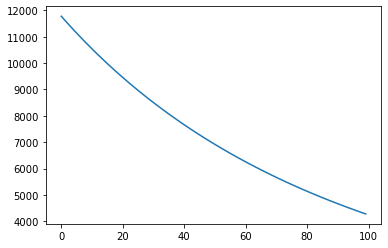

In [189]:
gridsize = 100
v1grid = np.linspace(output_est[0] - 0.1, output_est[0] + 0.1, gridsize)
hessv1 = np.zeros(gridsize)

for i in range(gridsize):
    
    hessv1[i] = ld.get_hessian(np.array([v1grid[i], output_est[1], output_est[2]]),
                           model.z, model.S, model.l, model.u, model.f, model.M)[0, 0]
    
fig, ax = plt.subplots()
ax.plot(hessv1)
plt.show()

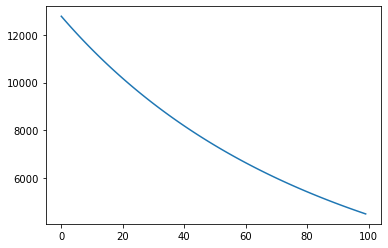

In [190]:
gridsize = 100
v2grid = np.linspace(output_est[1] - 0.1, output_est[1] + 0.1, gridsize)
hessv2 = np.zeros(gridsize)

for i in range(gridsize):
    
    hessv2[i] = ld.get_hessian(np.array([output_est[0], v2grid[i], output_est[2]]),
                           model.z, model.S, model.l, model.u, model.f, model.M)[1, 1]
    
fig, ax = plt.subplots()
ax.plot(hessv2)
plt.show()

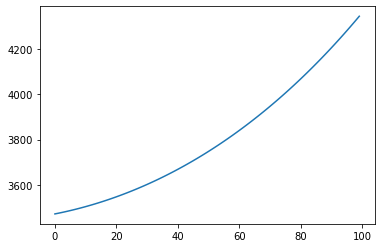

In [191]:
gridsize = 100
rgrid = np.linspace(output_est[2] - 0.1, output_est[2] + 0.1, gridsize)
hessr = np.zeros(gridsize)

for i in range(gridsize):
    
    hessr[i] = ld.get_hessian(np.array([output_est[0], output_est[1], rgrid[i]]),
                           model.z, model.S, model.l, model.u, model.f, model.M)[2, 2]
    
fig, ax = plt.subplots()
ax.plot(hessr)
plt.show()